# Scottish Highlands Snow Patches Monitoring System

**Automated satellite-based snow coverage tracking using Sentinel-2 imagery**

This notebook demonstrates the complete workflow:
1. 🗺️ **Interactive AOI Visualization** - View monitoring areas on map
2. 📡 **Data Discovery & Download** - Acquire winter satellite imagery
3. 🖼️ **Raw Data Visualization** - Display true-color Sentinel-2 images
4. ❄️ **Snow Detection** - Apply NDSI-based snow classification
5. 📊 **Trend Analysis** - Track snow coverage over time

---

## Setup

Import required modules and configure display settings.

In [1]:
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import sys
sys.path.append("..")

from data_handler.aoi import get_aois
from data_handler.notebook_utils import create_aoi_map
from data_handler.discovery import create_sh_config
from data_handler.demo_utils import (
    setup_database_and_aois,
    discover_and_download_winter_data,
    load_b03_images_from_db,
    plot_b03_images,
    compute_snow_masks_for_aoi,
    load_snow_masks_from_db,
    plot_snow_masks,
    analyze_snow_trends,
    plot_snow_trends
)

# Configure matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✓ Setup complete")

✓ Setup complete


## Configuration

Set parameters for data acquisition and analysis.

In [2]:
# Winter season to analyze
WINTER_YEAR = 2024  # Winter 2023/2024 (Dec 2023 - Feb 2024)

# Cloud cover threshold for data quality
MAX_CLOUD_COVER = 30.0  # percent

# NDSI threshold for snow classification
NDSI_THRESHOLD = 0.4  # Standard threshold for snow detection

# Limit downloads per AOI (None = no limit)
LIMIT_PER_AOI = 10  # Limit to 10 images per AOI for demo

# Database path
DB_PATH = "data/snow_patches_demo.db"

print(f"Configuration:")
print(f"  Winter: {WINTER_YEAR-1}/{WINTER_YEAR}")
print(f"  Max cloud cover: {MAX_CLOUD_COVER}%")
print(f"  NDSI threshold: {NDSI_THRESHOLD}")
print(f"  Images per AOI: {LIMIT_PER_AOI}")
print(f"  Database: {DB_PATH}")

Configuration:
  Winter: 2023/2024
  Max cloud cover: 30.0%
  NDSI threshold: 0.4
  Images per AOI: 10
  Database: data/snow_patches_demo.db


## 1. Interactive AOI Visualization 🗺️

View the Areas of Interest (AOIs) for snow monitoring on an interactive map.

In [3]:
# Load AOI definitions
aois_gdf = get_aois()

print(f"Monitoring {len(aois_gdf)} Areas of Interest:\n")
for _, aoi in aois_gdf.iterrows():
    print(f"  • {aoi['name']}: {aoi['size_km']}km² centered at ({aoi['center_lat']:.4f}°N, {aoi['center_lon']:.4f}°E)")

# Create interactive map
aoi_map = create_aoi_map(aois_gdf)
aoi_map

Monitoring 2 Areas of Interest:

  • Ben Nevis: 10.0km² centered at (56.7969°N, -5.0036°E)
  • Ben Macdui: 10.0km² centered at (57.0704°N, -3.6691°E)


## 2. Database Setup & Data Download 📡

Initialize the database and download satellite imagery for winter season.

### 2.1 Initialize Database

In [4]:
# Create database and insert AOIs
session, aoi_records = setup_database_and_aois(db_path=DB_PATH)

print(f"\n✓ Database initialized with {len(aoi_records)} AOIs")


✓ Database initialized with 2 AOIs


### 2.2 Configure Sentinel Hub API

In [5]:
# Load credentials from environment
client_id = os.getenv('SH_CLIENT_ID')
client_secret = os.getenv('SH_CLIENT_SECRET')

if not client_id or not client_secret:
    raise ValueError("Please set SH_CLIENT_ID and SH_CLIENT_SECRET environment variables")

# Create Sentinel Hub configuration
config = create_sh_config(client_id, client_secret)

print(f"✓ Sentinel Hub configured")
print(f"  Endpoint: {config.sh_base_url}")

✓ Sentinel Hub configured
  Endpoint: https://sh.dataspace.copernicus.eu


### 2.3 Discover and Download Winter Data

**Note:** This step makes real API calls and downloads satellite imagery. It may take several minutes.

In [6]:
# Discover and download data for all AOIs
stats = discover_and_download_winter_data(
    session=session,
    config=config,
    winter_year=WINTER_YEAR,
    max_cloud_cover=MAX_CLOUD_COVER,
    limit_per_aoi=LIMIT_PER_AOI
)

# Display summary
print(f"\n{'='*80}")
print("Download Summary")
print(f"{'='*80}")
print(f"  AOIs processed:        {stats['aois_processed']}")
print(f"  Products discovered:   {stats['products_discovered']}")
print(f"  Products inserted:     {stats['products_inserted']}")
print(f"  Products downloaded:   {stats['products_downloaded']}")
print(f"  Products failed:       {stats['products_failed']}")
print(f"{'='*80}")

# Show per-AOI breakdown
print(f"\nPer-AOI Breakdown:")
for aoi_name, aoi_stats in stats['details'].items():
    print(f"  {aoi_name}:")
    print(f"    - Discovered: {aoi_stats['products_discovered']}")
    print(f"    - Downloaded: {aoi_stats['products_downloaded']}")
    if aoi_stats['products_failed'] > 0:
        print(f"    - Failed: {aoi_stats['products_failed']}")


Processing AOI: Ben Nevis
  Center: (56.7969°N, -5.0036°E)
  Date range: 2023-12-01 to 2024-02-29
  Cloud threshold: 30.0%
  Discovering products...
  ✓ Found 14 products
  Limited to 10 products
  Inserting products into database...
    - 2024-02-24: Already exists (Cloud: 20.0%)
    - 2024-01-17: Already exists (Cloud: 2.1%)
    - 2024-01-15: Already exists (Cloud: 22.9%)
    - 2024-01-10: Already exists (Cloud: 15.6%)
    - 2024-01-07: Already exists (Cloud: 1.6%)
    - 2024-01-07: Already exists (Cloud: 5.5%)
    - 2023-12-26: Already exists (Cloud: 6.5%)
    - 2023-12-26: Already exists (Cloud: 15.7%)
    - 2023-12-13: Already exists (Cloud: 6.6%)
    - 2023-12-13: Already exists (Cloud: 19.4%)

Processing AOI: Ben Macdui
  Center: (57.0704°N, -3.6691°E)
  Date range: 2023-12-01 to 2024-02-29
  Cloud threshold: 30.0%
  Discovering products...
  ✓ Found 5 products
  Limited to 5 products
  Inserting products into database...
    - 2024-02-06: Already exists (Cloud: 26.9%)
    - 20

## 3. Raw Data Visualization 🖼️

Display the B03 (Green) band from downloaded Sentinel-2 imagery.

Loaded 9 B03 images for Ben Nevis


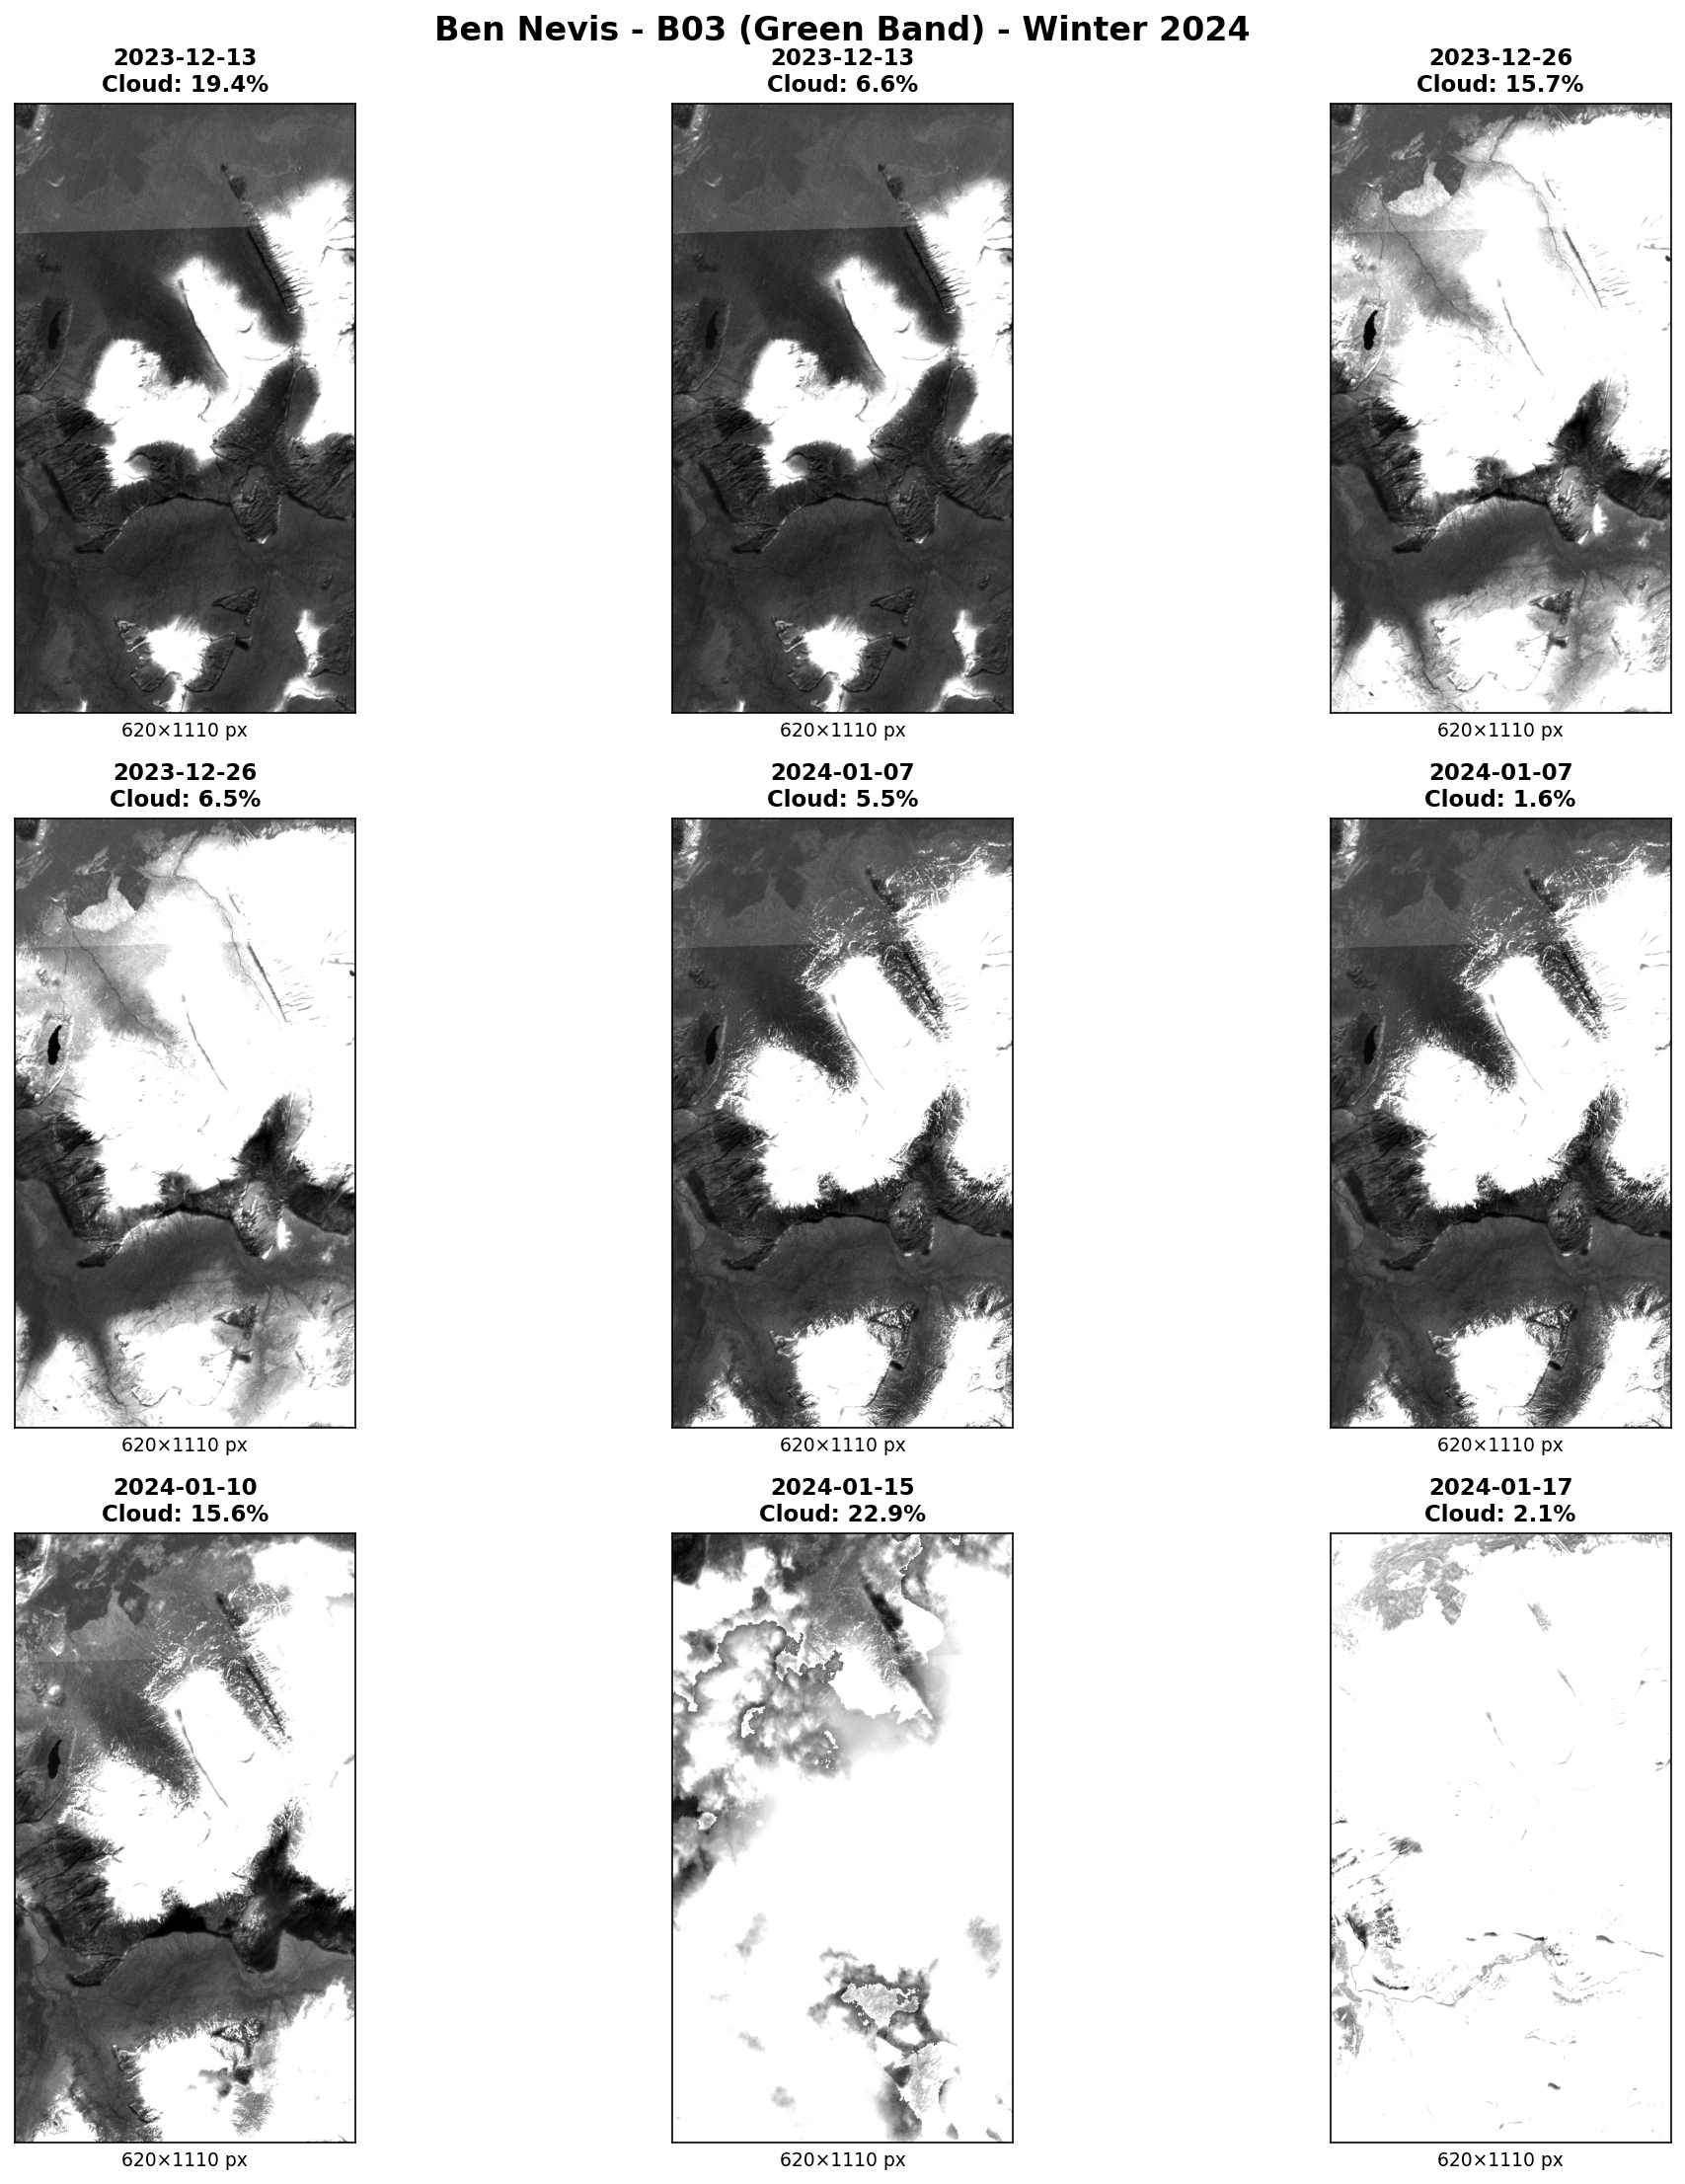

In [7]:
# Load B03 images for first AOI
first_aoi = aoi_records[0].name
b03_images = load_b03_images_from_db(session, aoi_name=first_aoi, limit=9)

print(f"Loaded {len(b03_images)} B03 images for {first_aoi}")

if len(b03_images) > 0:
    # Plot images
    fig = plot_b03_images(
        b03_images,
        title=f"{first_aoi} - B03 (Green Band) - Winter {WINTER_YEAR}",
        ncols=3,
        brightness_factor=3.0
    )
    plt.show()
else:
    print("No images available for visualization")

## 4. Snow Detection ❄️

Apply NDSI-based snow classification to identify snow-covered pixels.

### 4.1 Compute Snow Masks

In [8]:
# Compute snow masks for first AOI
snow_stats = compute_snow_masks_for_aoi(
    session=session,
    aoi_name=first_aoi,
    ndsi_threshold=NDSI_THRESHOLD,
    save_masks=True
)

print(f"\n✓ Snow mask computation complete")
print(f"  Average snow coverage: {snow_stats['avg_snow_pct']:.1f}%")


Computing snow masks for: Ben Nevis
  NDSI threshold: 0.4
  Save masks: True
  Found 0 downloaded products

✓ Snow mask computation complete
  Average snow coverage: 0.0%


### 4.2 Visualize Snow Masks

Loaded 9 snow masks for Ben Nevis


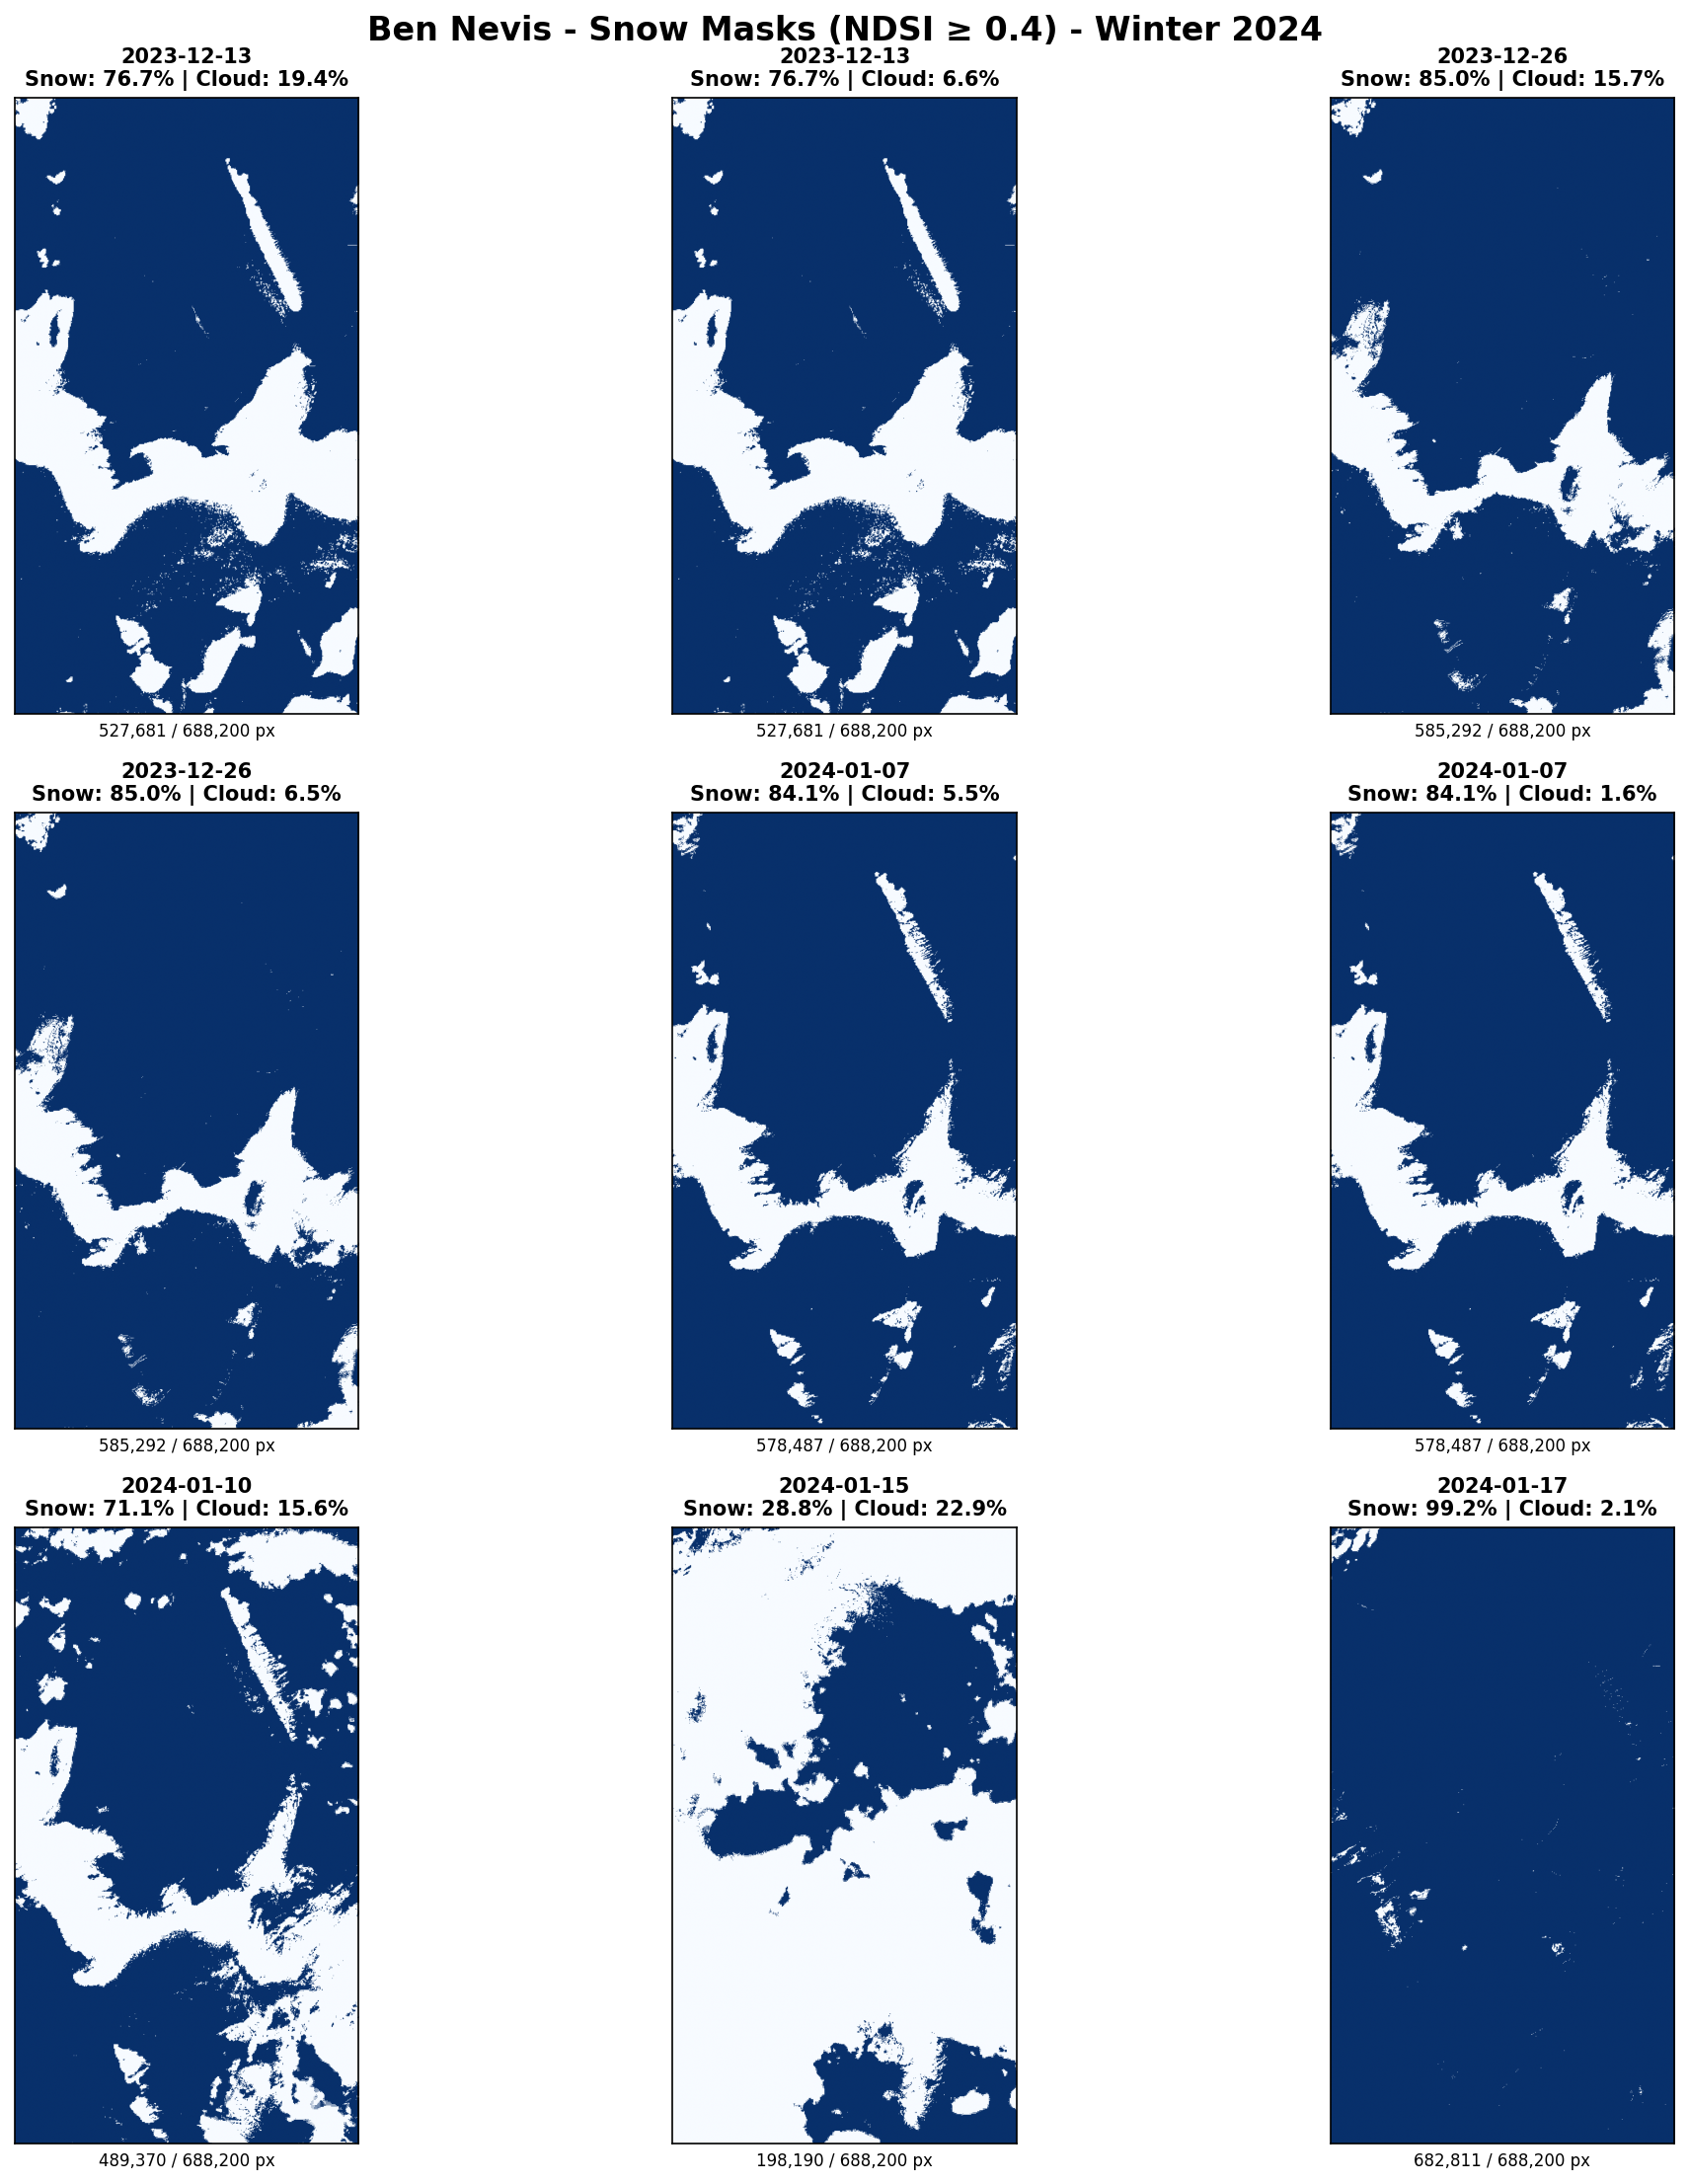

In [9]:
# Load and plot snow masks
snow_masks = load_snow_masks_from_db(session, aoi_name=first_aoi, limit=9)

print(f"Loaded {len(snow_masks)} snow masks for {first_aoi}")

if len(snow_masks) > 0:
    fig = plot_snow_masks(
        snow_masks,
        title=f"{first_aoi} - Snow Masks (NDSI ≥ {NDSI_THRESHOLD}) - Winter {WINTER_YEAR}",
        ncols=3
    )
    plt.show()
else:
    print("No snow masks available for visualization")

## 5. Snow Coverage Trends 📊

Analyze how snow coverage changes over the winter season.

Trend analysis for Ben Nevis:
  Observations: 10
  Date range: 2023-12-13 to 2024-02-24
  Snow coverage range: 28.8% - 99.2%
  Mean snow coverage: 75.7%

Data summary:


,date,snow_pct,cloud_cover
0,2023-12-13 11:35:24.862,76.675530,19.40
1,2023-12-13 11:35:39.589,76.675530,6.56
2,2023-12-26 11:45:24.376,85.046789,15.66
3,2023-12-26 11:45:38.356,85.046789,6.47
4,2024-01-07 11:35:28.602,84.057977,5.53
5,2024-01-07 11:35:43.330,84.057977,1.55
6,2024-01-10 11:45:39.569,71.108689,15.62
7,2024-01-15 11:45:34.200,28.798314,22.88
8,2024-01-17 11:35:43.163,99.216943,2.13
9,2024-02-24 11:45:25.902,66.594449,20.00


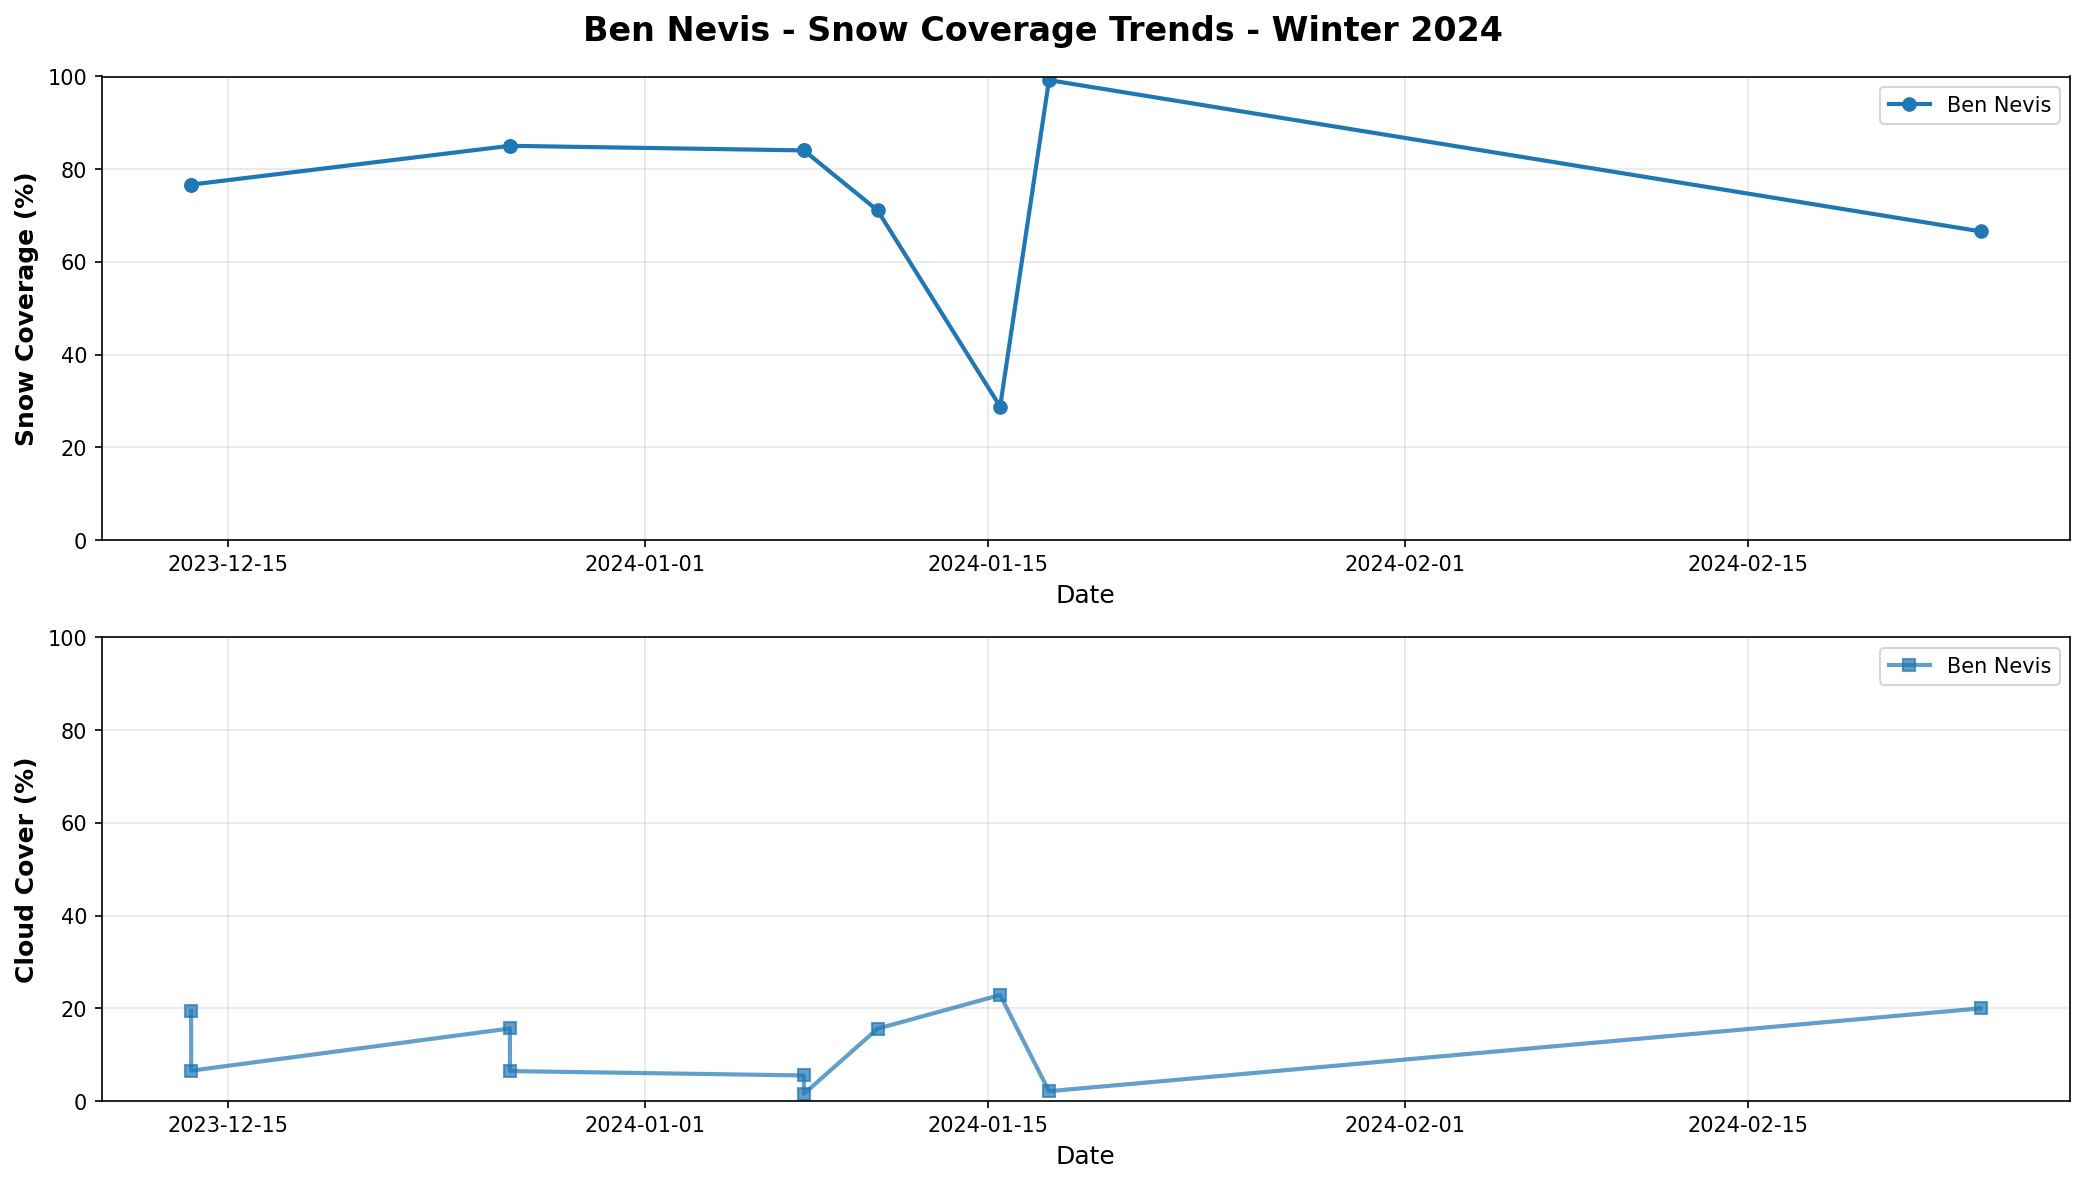

In [10]:
# Analyze trends for first AOI
trends_df = analyze_snow_trends(session, aoi_name=first_aoi)

print(f"Trend analysis for {first_aoi}:")
print(f"  Observations: {len(trends_df)}")

if len(trends_df) > 0:
    print(f"  Date range: {trends_df['date'].min().date()} to {trends_df['date'].max().date()}")
    print(f"  Snow coverage range: {trends_df['snow_pct'].min():.1f}% - {trends_df['snow_pct'].max():.1f}%")
    print(f"  Mean snow coverage: {trends_df['snow_pct'].mean():.1f}%")
    
    # Display data table
    print(f"\nData summary:")
    display(trends_df[['date', 'snow_pct', 'cloud_cover']].head(10))
    
    # Plot trends
    fig = plot_snow_trends(
        trends_df,
        title=f"{first_aoi} - Snow Coverage Trends - Winter {WINTER_YEAR}",
        figsize=(14, 8)
    )
    plt.show()
else:
    print("No trend data available")

## 6. Multi-AOI Comparison (Optional)

Compare snow trends across all monitored areas.

Processing additional AOIs for comparison...


Computing snow masks for: Ben Macdui
  NDSI threshold: 0.4
  Save masks: True
  Found 0 downloaded products

Comparing 2 AOIs:
  Ben Macdui:
    - Observations: 5
    - Mean snow coverage: 67.7%
    - Range: 29.6% - 98.9%
  Ben Nevis:
    - Observations: 10
    - Mean snow coverage: 75.7%
    - Range: 28.8% - 99.2%


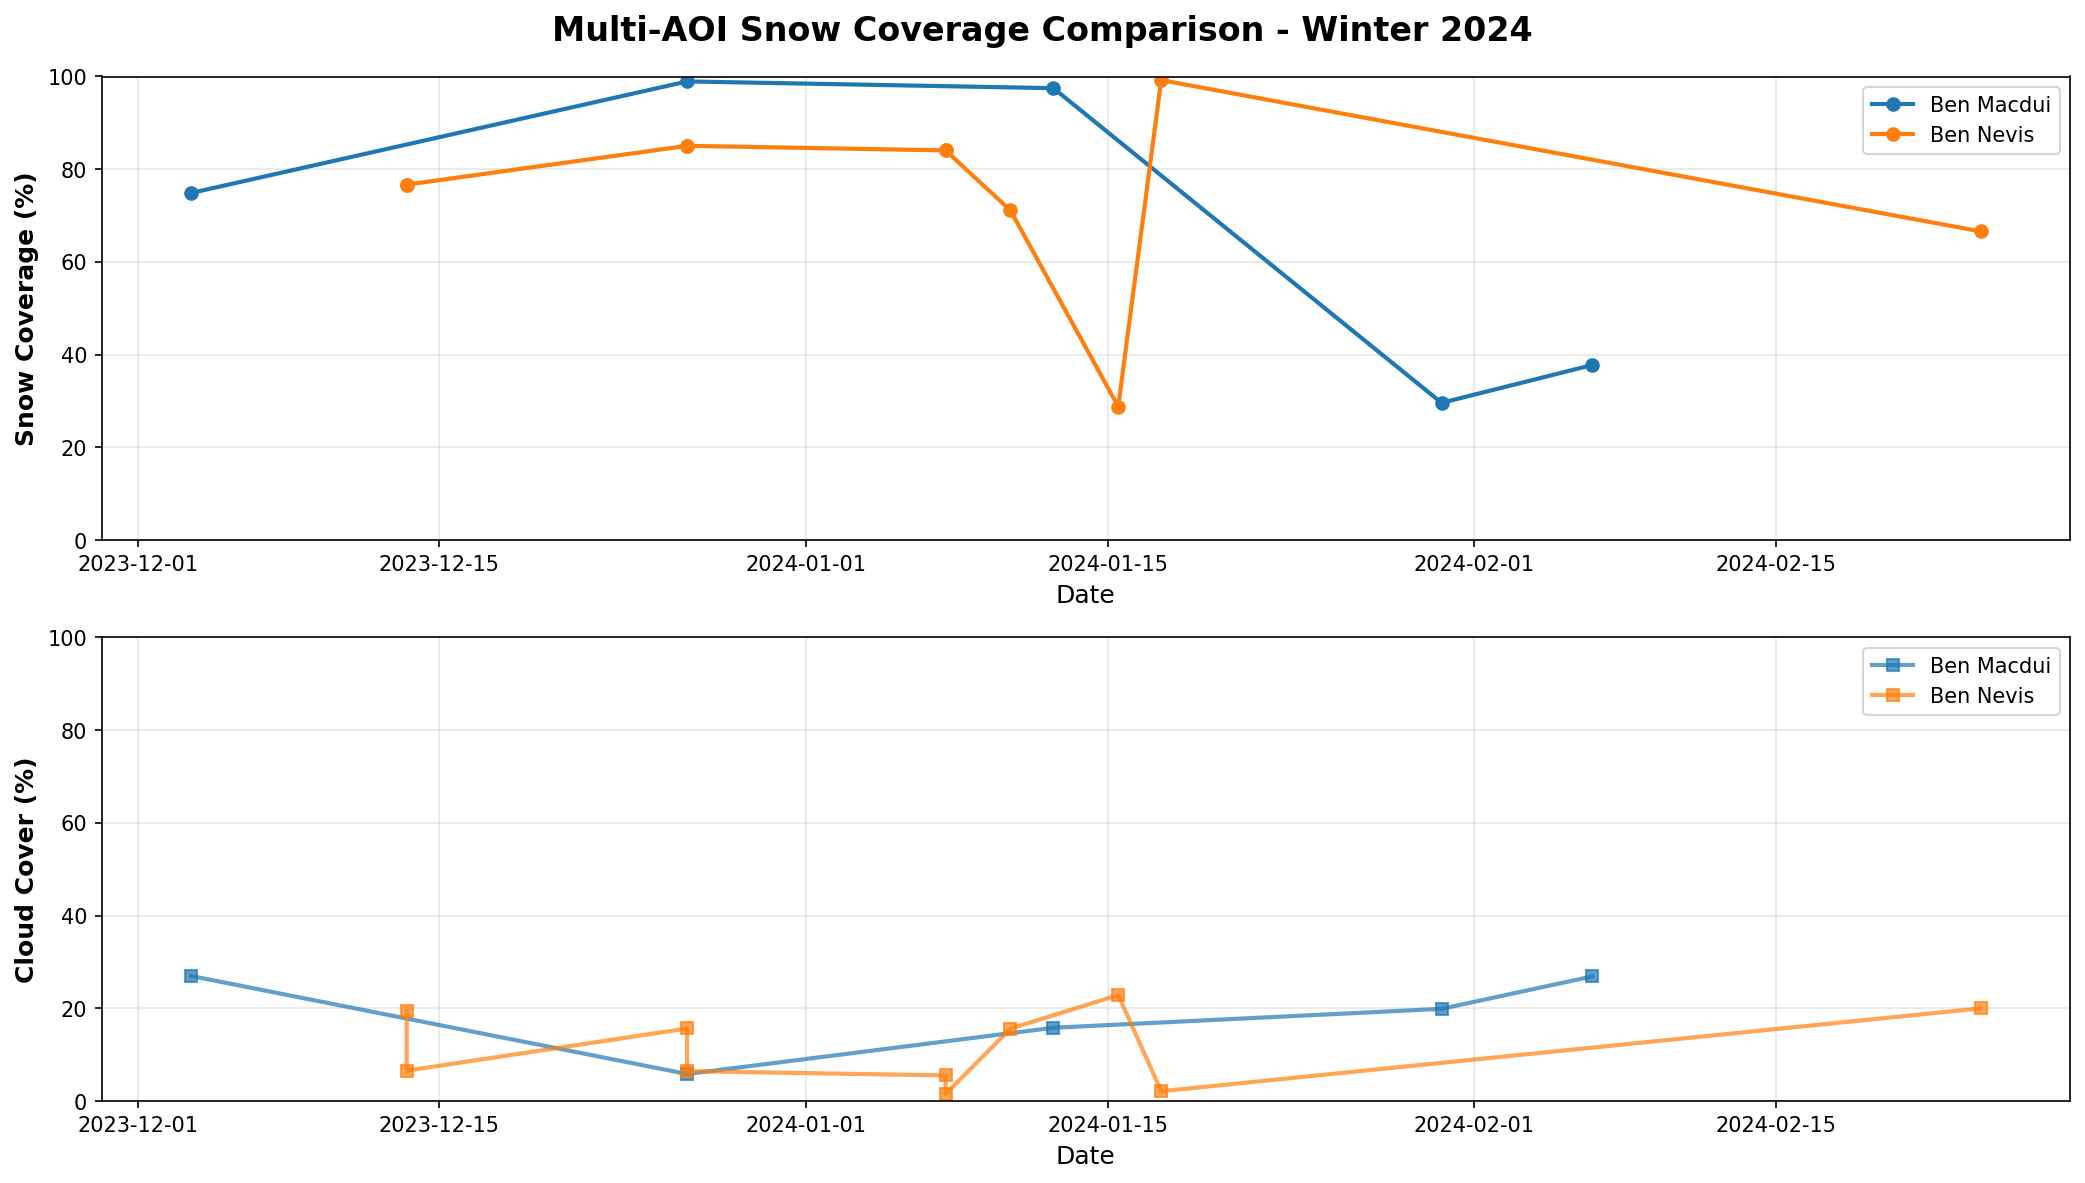

In [11]:
# Process remaining AOIs if available
if len(aoi_records) > 1:
    print("Processing additional AOIs for comparison...\n")
    
    for aoi in aoi_records[1:]:
        # Compute snow masks
        compute_snow_masks_for_aoi(
            session=session,
            aoi_name=aoi.name,
            ndsi_threshold=NDSI_THRESHOLD,
            save_masks=True
        )
    
    # Analyze trends for all AOIs
    all_trends = analyze_snow_trends(session)
    
    if len(all_trends) > 0:
        print(f"\nComparing {len(aoi_records)} AOIs:")
        
        # Show statistics by AOI
        for aoi_name in all_trends['aoi_name'].unique():
            aoi_data = all_trends[all_trends['aoi_name'] == aoi_name]
            print(f"  {aoi_name}:")
            print(f"    - Observations: {len(aoi_data)}")
            print(f"    - Mean snow coverage: {aoi_data['snow_pct'].mean():.1f}%")
            print(f"    - Range: {aoi_data['snow_pct'].min():.1f}% - {aoi_data['snow_pct'].max():.1f}%")
        
        # Plot comparison
        fig = plot_snow_trends(
            all_trends,
            title=f"Multi-AOI Snow Coverage Comparison - Winter {WINTER_YEAR}",
            figsize=(14, 8)
        )
        plt.show()
else:
    print("Only one AOI configured - skipping comparison")

## Summary

**Workflow Complete!** ✅

This notebook demonstrated:
- ✓ Interactive AOI visualization on map
- ✓ Automated satellite data discovery and download
- ✓ Raw imagery visualization (B03 band)
- ✓ NDSI-based snow detection and classification
- ✓ Time series analysis of snow coverage trends

**Next Steps:**
- Expand to additional winter seasons for multi-year comparison
- Implement automated alerts when snow coverage drops below threshold
- Export results to web dashboard or report
- Add climate data integration (temperature, precipitation)

---

*Generated with Python, Sentinel-2 data, and ❄️*

In [12]:
# Clean up
session.close()
print("✓ Session closed")

✓ Session closed


Snow Mask Diagnostics:
  Date: 2023-12-13
  Stored snow_pct: 76.7%
  Shape: (1110, 620)
  Unique values: [0 1]
  Zeros (no snow): 160,519 pixels (23.3%)
  Ones (snow): 527,681 pixels (76.7%)
(array([160519,      0,      0,      0,      0,      0,      0,      0,
            0, 527681]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


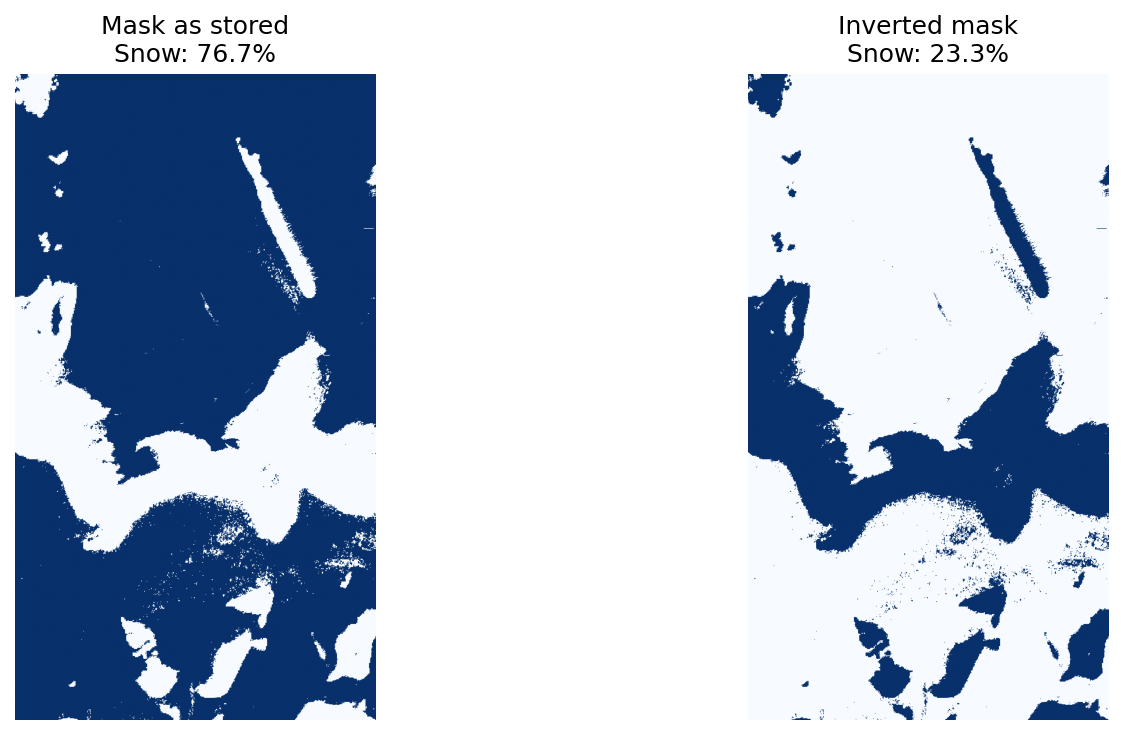


If the LEFT image looks correct, no inversion.
If the RIGHT image looks correct, there IS an inversion bug!


In [18]:
# Diagnostic: Check snow mask values                                                                             
import numpy as np                                                                                               
import rasterio                                                                                                  
                                                                                                               
# Get first snow mask from database                                                                              
masks = load_snow_masks_from_db(session, aoi_name=first_aoi, limit=1)                                            
                                                                                                               
if masks:                                                                                                        
  mask_data = masks[0]                                                                                         
  mask = mask_data['mask']                                                                                     
                                                                                                               
  print(f"Snow Mask Diagnostics:")                                                                             
  print(f"  Date: {mask_data['date'].date()}")                                                                 
  print(f"  Stored snow_pct: {mask_data['snow_pct']:.1f}%")                                                    
  print(f"  Shape: {mask.shape}")                                                                              
  print(f"  Unique values: {np.unique(mask)}")                                                                 
  print(f"  Zeros (no snow): {np.sum(mask == 0):,} pixels ({np.sum(mask == 0)/mask.size*100:.1f}%)")           
  print(f"  Ones (snow): {np.sum(mask == 1):,} pixels ({np.sum(mask == 1)/mask.size*100:.1f}%)")               
                                                                                                               
  # Visual check                                                                                               
  import matplotlib.pyplot as plt                                                                              
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))                                                        
                                                                                                               
  # Original mask                                                                                              
  ax1.imshow(mask, cmap='Blues', vmin=0, vmax=1)                                                               
  ax1.set_title(f'Mask as stored\nSnow: {mask_data["snow_pct"]:.1f}%')                                         
  ax1.axis('off')
  print(np.histogram(mask))
                                                                                                               
  # Inverted mask                                                                                              
  ax2.imshow(1 - mask, cmap='Blues', vmin=0, vmax=1)                                                           
  ax2.set_title(f'Inverted mask\nSnow: {100-mask_data["snow_pct"]:.1f}%')                                      
  ax2.axis('off')                                                                                              
                                                                                                               
  plt.tight_layout()                                                                                           
  plt.show()                                                                                                   
                                                                                                               
  print(f"\nIf the LEFT image looks correct, no inversion.")                                                   
  print(f"If the RIGHT image looks correct, there IS an inversion bug!")